
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)

<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">



<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
The project can be pulled into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.

</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

In [6]:
%run ./includes/includes

Exception: File `'./includes/includes'` not found.

In [ ]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

Cleared all previous data.


## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [ ]:
spark.conf.get("spark.sql.shuffle.partitions")

Out[7]: '200'

The current setting of 200 shuffle partitions in your Spark configuration may not be optimal for your cluster setup, which includes only one worker with 4 cores. Typically, a large number of shuffle partitions (like 200) is more suitable for larger clusters with many executors and cores. For our setup, having a high number of partitions can lead to inefficiencies due to increased scheduling overhead and network costs during data shuffling.
To improve performance, consider reducing the number of shuffle partitions to better match the number of cores in your cluster. A more suitable number might be closer to 4-8 shuffle partitions. This adjustment helps minimize overhead and can enhance the performance of operations involving shuffling, such as joins or aggregations. Always monitor the performance impacts of any changes and adjust based on observed behavior and workload characteristics.

In [ ]:

# Import necessary libraries for Spark, Delta Lake, MLflow, and Hugging Face Transformers
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from delta import *
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.pyfunc

# Import Hugging Face libraries for sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set up the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")


/local_disk0/.ephemeral_nfs/envs/pythonEnv-ba975837-8668-4680-a09d-980b7c5e2b6e/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Assuming SparkSession is already created in Databricks as `spark`
# If not, you would need to create it:
spark = SparkSession.builder.appName("TweetSentimentAnalysis").getOrCreate()

# Provided variables from your environment
TWEET_SOURCE_PATH = "s3a://voc-75-databricks-data/voc_volume/" 
# Utility function to list files in a directory
def list_files_in_directory(directory_path):
    return dbutils.fs.ls(directory_path)

# Utility function to count the number of files in a directory
def count_files_in_directory(directory_path):
    return len(list_files_in_directory(directory_path))

# Use the utility functions
files = list_files_in_directory(TWEET_SOURCE_PATH)

# Count the source files
file_count = count_files_in_directory(TWEET_SOURCE_PATH)
print(f"Number of files in the source directory: {file_count}")

# Print the contents of the first file (if it exists)
if files:
    first_file_path = files[0].path  # The path includes 'dbfs:' automatically
    file_contents = spark.read.text(first_file_path).collect()
    for row in file_contents:
        print(row.value)


Number of files in the source directory: 200001
{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from pyspark.sql.functions import input_file_name, current_timestamp

# Define the schema for the incoming JSON data
bronze_schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("source_file", StringType(), True),
    StructField("processing_time", TimestampType(), True)
])

# Read the stream with CloudFiles and immediately capture the source file
raw_stream_df = (
    spark.readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")
    .schema(bronze_schema)
    .load("s3a://voc-75-databricks-data/voc_volume")
)

# If 'source_file' is part of the loaded data, ensure not to duplicate it.
# Check if 'source_file' needs to be explicitly captured or just ensure it's correctly handled.
processed_stream_df = raw_stream_df.withColumn("processing_time", current_timestamp()).withColumn("source_file",input_file_name())

# Ensure that there's no accidental duplication of 'source_file'
#if "source_file" not in processed_stream_df.columns:
 #   processed_stream_df = processed_stream_df.withColumn("source_file", input_file_name())

In [ ]:
# Write the processed stream to a Delta table in append mode
bronze_stream_query = (
    processed_stream_df.writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", "/tmp/labuser104917-3010936/bronze.checkpoint")
    .option("mergeSchema", "true")
    .queryName("bronze_stream")
    .start("/tmp/labuser104917-3010936/bronze.delta")
)


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Define the schema for the incoming JSON data
bronze_schema = StructType([
    StructField("date", StringType(), True),  # Assuming dates are in string format; consider converting to date type later
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("source_file", StringType(), True),
    StructField("processing_time", TimestampType(), True)  # Automatically capture the processing timestamp
])

In [ ]:
BRONZE_DELTA="/tmp/labuser104917-3010936/bronze.delta"
# Read the Bronze Delta table into a DataFrame
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)
# Count the number of tweets
tweet_count = bronze_df.count()
print(f"Total number of tweets captured: {tweet_count}")
bronze_df.count()

Total number of tweets captured: 10999
Out[14]: 10999

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [ ]:
# Load the Bronze Delta table
bronze_df = spark.read.format("delta").load("/tmp/labuser104917-3010936/bronze.delta")

# Count the number of tweets
tweet_count = bronze_df.count()
print(f"Total number of tweets: {tweet_count}")


Total number of tweets: 10999


In [ ]:
from pyspark.sql.functions import input_file_name, current_timestamp, col, isnan, when, count

# Load the Bronze Delta table and add source_file and processing_time
bronze_df = (spark.read.format("delta")
             .load("/tmp/labuser104917-3010936/bronze.delta")
             .withColumn("source_file", input_file_name())
             .withColumn("processing_time", current_timestamp()))

# Check for nulls in the dataframe
null_checks = bronze_df.select([count(when(col(c).isNull(), c)).alias(c) for c in bronze_df.columns])
null_checks.show()


+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [ ]:
from pyspark.sql.functions import desc

# Group by user handle, count tweets, and order by the count in descending order
tweets_per_user = bronze_df.groupBy("user").count().orderBy(desc("count"))
tweets_per_user.show()


+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|   63|
|   Jamiescott19|   10|
|  DonniesGirl69|    9|
|     rgoodchild|    9|
| scottfaithfull|    8|
|      MCRmuffin|    8|
|archangelmaggie|    7|
|  christinajade|    7|
|          ahsan|    6|
|       clara018|    6|
| SUGARvampchick|    6|
| BrandySanDiego|    6|
|        newsage|    5|
|     smilinggal|    5|
|    TheMacMommy|    5|
|        Cherrim|    5|
| aussiemcflyfan|    5|
|  southportlush|    5|
|  billingtonart|    5|
|  JonasLovato24|    5|
+---------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import expr

# Count tweets with and without mentions
mentions_count = bronze_df.withColumn("has_mention", expr("text LIKE '%@%'"))
tweet_mention_stats = mentions_count.groupBy("has_mention").count()
tweet_mention_stats.show()


+-----------+-----+
|has_mention|count|
+-----------+-----+
|       true| 5313|
|      false| 5686|
+-----------+-----+



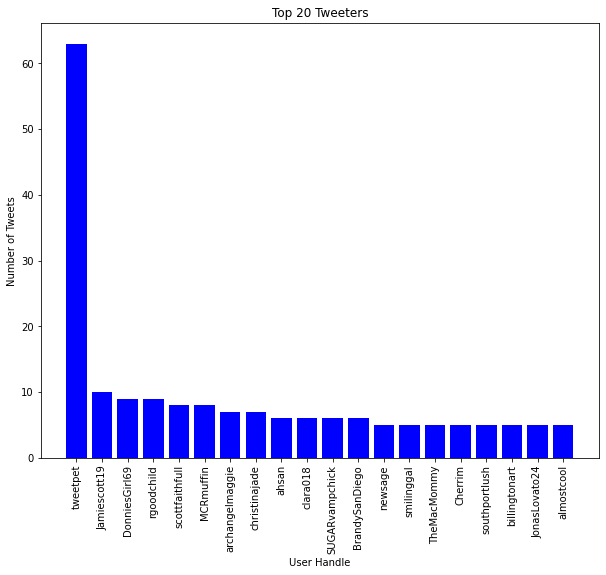

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
top_tweeters = tweets_per_user.toPandas().head(20)

# Plot the top 20 tweeters
plt.figure(figsize=(10, 8))
plt.bar(top_tweeters['user'], top_tweeters['count'], color='blue')
plt.xlabel('User Handle')
plt.ylabel('Number of Tweets')
plt.title('Top 20 Tweeters')
plt.xticks(rotation=90)
plt.show()


## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Define the Silver data schema
silver_data_schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("mention", StringType(), True),
    StructField("cleaned_text", StringType(), True),
    StructField("sentiment", StringType(), True)
])

In [ ]:
from pyspark.sql.functions import col, to_timestamp, expr

In [ ]:
bronze_df = (
    spark.readStream
    .format("delta")
    .option("path", BRONZE_DELTA)
    .load()
)

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [ ]:
from pyspark.sql.functions import col, to_timestamp, explode_outer, regexp_replace, split, expr


date_format = "EEE MMM dd HH:mm:ss z yyyy"

silver_df = bronze_df.select(
    to_timestamp(col("date"), date_format).alias("timestamp"),
    expr("explode_outer(split(text, ' ')) as word"),
    regexp_replace(col("text"), "@\\w+", "").alias("cleaned_text"),
    col("sentiment")
).where(col("word").rlike("^@\\w+"))

# Transform to have rows for each mention specifically
silver_expanded_df = silver_df.select(
    "timestamp",
    expr("substring(word, 2) as mention"),  # Remove '@' from the mention
    "cleaned_text",
    "sentiment"
)

In [ ]:
#SILVER_CHECKPOINT="/tmp/labuser104917-3010936/silver.checkpoint"
silver_stream = (
    silver_expanded_df
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .start(SILVER_DELTA)
)

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [ ]:
%pip install mlflow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
SILVER_DELTA="/tmp/labuser104917-3010936/silver.delta"
spark = SparkSession.builder \
    .appName("Read Silver Data") \
    .getOrCreate()

silver_temp = spark.read.format("delta").load(SILVER_DELTA)
display(silver_temp)
silver_temp.count()

timestamp mention cleaned_text sentiment 2009-05-02T06:08:23.000+0000 cali3d Not really, it may look specific, but the message merely tells me some invalid tag was sent by "something" to "somwhere". negative 2009-05-02T06:11:00.000+0000 billbeckett ...I think they ran out of ideas. I want his shoes. "What's your name pilgrim?!...wait, what?" haha I love the bloopers (L) positive 2009-04-07T10:44:04.000+0000 JLSOfficial cup of tea is the way to go!!! have fun on your photoshoot!! and have a fun free day writing oo i dunno a blog? & The studio positive 2009-05-02T05:55:58.000+0000 Mrsdaughtry Awe! They're getting big Oh man, watch out for those teen years. It's good that you & Hannah are so close though! Cherish it positive 2009-05-02T06:01:23.000+0000 JBMovies yes yes! I still like to remember when it was fun to use "new tech" rather than having to use it or it becoming a standard. positive 2009-05-02T05:55:11.000+0000 Hatz94 WHAT?!because of David? makes me want to cry. who would do that?! you're really strong for not telling him that, he would hate it negative 2009-05-02T06:00:38.000+0000 HibaNick fuck 'em, they have no right telling u 2 grow up! you're a beautiful girl hun don't be in a rush to grow up FOR ANYBODY! x0x0x positive 2009-04-07T10:45:33.000+0000 DeuceWT i am!!!!! then we gotta meet in Royal oak with some stylists for these shows... THEN we got a show tonight... man, ima be tired negative 2009-05-02T05:58:48.000+0000 Joshyxspicenz Yeah, I wish that too! I voted for him a lot & was suprised he was in the btm2! I dialed 18664365710 via landline a lot! negative 2009-05-02T06:03:47.000+0000 Hatz94 lol it's like 2 AM here, hooray! but are you like, clinically diagnosed with it? is there medicine you could take or something? negative 2009-05-02T06:05:48.000+0000 officialjobros http://twitpic.com/4diat - i dont know how to send links to you guys so here's my pic...notice the shirt love you guy ... positive 2009-05-02T06:11:01.000+0000 IdahoNews taking the girl on her first 5k, nothing big just a jog Want to go trail running tomorrow later maybe too, good luck w/ur run positive 2009-05-02T05:56:05.000+0000 Raeknightowl4 Hey Rae I've had a tummy bug since last night...sad times...but other thank that...things are great..graduation nxt wk! positive 2009-05-02T05:51:14.000+0000 RealHughJackman Since it's slow Mountaineer news day, Wolverine is pretty good, but maybe not same level as X-men movies Good job though positive 2009-05-02T06:01:13.000+0000 RealHughJackman Hi Hugh! Im watching Craig Ferguson and Ryan Reynolds said your nipples are made of actual diamonds! Is this true? positive 2009-05-02T06:11:24.000+0000 triplejdools Do you have a sales strategy? What's your sales-pitch? Are you convincing people they look good? Don't lie, they trust you. positive 2009-04-07T10:44:23.000+0000 HilzFuld only trouble with tread type iPhone cases is it's hard to put into and take out of pockets... Otherwise, very impact resistant positive 2009-05-02T06:07:56.000+0000 booggie, 2)Something funny that Janae said but now I don't remember. Fyi , I wasn't keeping secret the tv, only that I was mad having it. negative 2009-05-02T06:09:43.000+0000 jennaberman no Playoffs this week tues n thurs and get out first loose. Bad part if if they make it to finals askin won't be there... negative 2009-05-02T06:10:55.000+0000 jennfantastic alrighty, last comment and im off to shower and after that, blankey rapey time x'D I LOVE YOU NUNK! :] SWEET DREAMS <3 positive 2009-05-02T06:13:51.000+0000 davidismyangel yay! but omg, that seriously upset me what Daniel said poorr him! and what would David think? D: P.S. 500th update! negative 2009-05-02T05:50:52.000+0000 websmith1 Thanks. Mother's day coming up... Sorry to hear about your dad. I still have my dad. I hope you had a nice day with your mom positive 2009-05-02T05:51:09.000+0000 Peties_Pam LOL well I missed that altogether didn't I? lol & yes, that 2 is a challenge sometimes...life seems 2 b full of t

Out[7]: 5565

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when
import mlflow.pyfunc
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
GOLD_DELTA="/tmp/labuser104917-3010936/gold.delta"
GOLD_CHECKPOINT="/tmp/labuser104917-3010936/gold.checkpoint"
MODEL_NAME="HF_TWEET_SENTIMENT"
spark = SparkSession.builder \
    .appName("Transform Silver to Gold Data") \
    .getOrCreate()

model = mlflow.pyfunc.spark_udf(spark,model_uri=f"models:/{MODEL_NAME}/production")

silver_df = (spark.readStream
                  .format("delta")
                  .load(SILVER_DELTA))

gold_df = (silver_df.withColumn("predicted_sentiment_info", model(col("cleaned_text")))
           .withColumn("predicted_sentiment_id",
                       when(col("predicted_sentiment_info").getItem("label") == "POS", 1)
                                .otherwise(0))
           .withColumn("predicted_score",col("predicted_sentiment_info").getItem("score")*100).withColumn("sentiment_id", 
                                when(col("Sentiment") == "negative", 0)
                                .when(col("Sentiment") == "positive", 1)
                                .otherwise(None))
                    .select(
                        col("timestamp"), 
                        col("mention"), 
                        col("cleaned_text"), 
                        col("Sentiment"),
                        col("predicted_score"),
                        col("predicted_sentiment_info").getItem("label").alias("predicted_sentiment"),
                        col("sentiment_id"),
                        col("predicted_sentiment_id")))
gold_stream = (gold_df.writeStream
                      .outputMode("append")
                      .format("delta")
                      .queryName("gold_stream")
                      .option("checkpointLocation", GOLD_CHECKPOINT)
                      .start(GOLD_DELTA)) 

2024/05/12 02:50:57 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 02:51:01 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/12 02:51:01 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 02:51:01 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [ ]:
park = SparkSession.builder \
    .appName("Read Gold Data") \
    .getOrCreate()

gold_temp = spark.read.format("delta").load(GOLD_DELTA)
display(gold_temp)

timestamp mention cleaned_text Sentiment predicted_score predicted_sentiment sentiment_id predicted_sentiment_id 2009-05-02T06:08:23.000+0000 cali3d Not really, it may look specific, but the message merely tells me some invalid tag was sent by "something" to "somwhere". negative 77.86160111427307 NEG 0 0 2009-05-02T06:11:00.000+0000 billbeckett ...I think they ran out of ideas. I want his shoes. "What's your name pilgrim?!...wait, what?" haha I love the bloopers (L) positive 93.24448704719543 POS 1 1 2009-04-07T10:44:04.000+0000 JLSOfficial cup of tea is the way to go!!! have fun on your photoshoot!! and have a fun free day writing oo i dunno a blog? & The studio positive 99.17489290237427 POS 1 1 2009-05-02T05:55:58.000+0000 Mrsdaughtry Awe! They're getting big Oh man, watch out for those teen years. It's good that you & Hannah are so close though! Cherish it positive 99.19677376747131 POS 1 1 2009-05-02T06:01:23.000+0000 JBMovies yes yes! I still like to remember when it was fun to use "new tech" rather than having to use it or it becoming a standard. positive 91.63693189620972 POS 1 1 2009-05-02T05:55:11.000+0000 Hatz94 WHAT?!because of David? makes me want to cry. who would do that?! you're really strong for not telling him that, he would hate it negative 88.56829404830933 NEG 0 0 2009-05-02T06:00:38.000+0000 HibaNick fuck 'em, they have no right telling u 2 grow up! you're a beautiful girl hun don't be in a rush to grow up FOR ANYBODY! x0x0x positive 39.24480676651001 NEG 1 0 2009-04-07T10:45:33.000+0000 DeuceWT i am!!!!! then we gotta meet in Royal oak with some stylists for these shows... THEN we got a show tonight... man, ima be tired negative 50.166475772857666 NEG 0 0 2009-05-02T05:58:48.000+0000 Joshyxspicenz Yeah, I wish that too! I voted for him a lot & was suprised he was in the btm2! I dialed 18664365710 via landline a lot! negative 97.25502729415894 POS 0 1 2009-05-02T06:03:47.000+0000 Hatz94 lol it's like 2 AM here, hooray! but are you like, clinically diagnosed with it? is there medicine you could take or something? negative 70.5040693283081 POS 0 1 2009-05-02T06:05:48.000+0000 officialjobros http://twitpic.com/4diat - i dont know how to send links to you guys so here's my pic...notice the shirt love you guy ... positive 97.59332537651062 POS 1 1 2009-05-02T06:11:01.000+0000 IdahoNews taking the girl on her first 5k, nothing big just a jog Want to go trail running tomorrow later maybe too, good luck w/ur run positive 88.77321481704712 POS 1 1 2009-05-02T05:56:05.000+0000 Raeknightowl4 Hey Rae I've had a tummy bug since last night...sad times...but other thank that...things are great..graduation nxt wk! positive 38.01003396511078 NEG 1 0 2009-05-02T05:51:14.000+0000 RealHughJackman Since it's slow Mountaineer news day, Wolverine is pretty good, but maybe not same level as X-men movies Good job though positive 92.34814643859863 POS 1 1 2009-05-02T06:01:13.000+0000 RealHughJackman Hi Hugh! Im watching Craig Ferguson and Ryan Reynolds said your nipples are made of actual diamonds! Is this true? positive 87.29239702224731 NEU 1 0 2009-05-02T06:11:24.000+0000 triplejdools Do you have a sales strategy? What's your sales-pitch? Are you convincing people they look good? Don't lie, they trust you. positive 54.144781827926636 NEU 1 0 2009-04-07T10:44:23.000+0000 HilzFuld only trouble with tread type iPhone cases is it's hard to put into and take out of pockets... Otherwise, very impact resistant positive 75.0185489654541 NEG 1 0 2009-05-02T06:07:56.000+0000 booggie, 2)Something funny that Janae said but now I don't remember. Fyi , I wasn't keeping secret the tv, only that I was mad having it. negative 69.52089071273804 NEU 0 0 2009-05-02T06:09:43.000+0000 jennaberman no Playoffs this week tues n thurs and get out first loose. Bad part if if they make it to finals askin won't be there... negative 97.17695116996765 NEG 0 0 2009-05-02T06:10:55.000+0000 jennfantastic alrighty, last comment and im off to shower and after tha

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [ ]:
!pip install mlflow

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [ ]:
gold_table_df = spark.read.format("delta").load(GOLD_DELTA)
gold_df_pd = gold_table_df.toPandas()
# Map 'Neutral' sentiment to 'Positive'
gold_df_pd['predicted_sentiment_id'] = gold_df_pd['predicted_sentiment_id'].replace(-1, 1)
y_true = gold_df_pd["sentiment_id"]
y_pred = gold_df_pd["predicted_sentiment_id"]
     

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [ ]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Start an MLflow run
with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Store the model name and MLflow version as parameters
    mlflow.log_param("model_name", "tweets_sentiment_analysis")
    mlflow.log_param("mlflow_version", mlflow.__version__)  # Correct attribute for MLflow version

    # Store the version of the Delta Table (input-silver) as an MLflow parameter
    mlflow.log_param("delta_table_version", "2")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)  # Make sure y_true and y_pred are defined appropriately
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    confusion_matrix_path = "confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    plt.close()

    # Log confusion matrix image as an artifact
    mlflow.log_artifact(confusion_matrix_path)


In [ ]:
mlflow.end_run()

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)


*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
GOLD_DELTA="/tmp/labuser104917-3010936/gold.delta"
# Initialize Spark session
spark = SparkSession.builder.appName("Application Data Processing").getOrCreate()

# Load Gold Delta Table

gold_df = spark.read.format("delta").load(GOLD_DELTA)

# Aggregate data by mention
aggregated_df = gold_df.groupBy("mention").agg(
    count(when(col("sentiment") == "neutral", True)).alias("neutral_count"),
    count(when(col("sentiment") == "positive", True)).alias("positive_count"),
    count(when(col("sentiment") == "negative", True)).alias("negative_count"),
    count("mention").alias("total_mentions")
).sort(col("total_mentions").desc())


In [ ]:
aggregated_df.show()


+---------------+-------------+--------------+--------------+--------------+
|        mention|neutral_count|positive_count|negative_count|total_mentions|
+---------------+-------------+--------------+--------------+--------------+
|     mileycyrus|            0|            32|            10|            42|
|   jordanknight|            0|            12|            13|            25|
|RealHughJackman|            0|            17|             3|            20|
|       ddlovato|            0|            15|             4|            19|
|    selenagomez|            0|            13|             4|            17|
|    heidimontag|            0|            13|             2|            15|
|       Rove1974|            0|             0|            10|            10|
|JonathanRKnight|            0|             7|             3|            10|
|    RetroRewind|            0|             7|             3|            10|
|         Schofe|            0|             8|             2|            10|

In [ ]:
# Convert to Pandas DataFrame for plotting
mention_pdf = aggregated_df.toPandas()


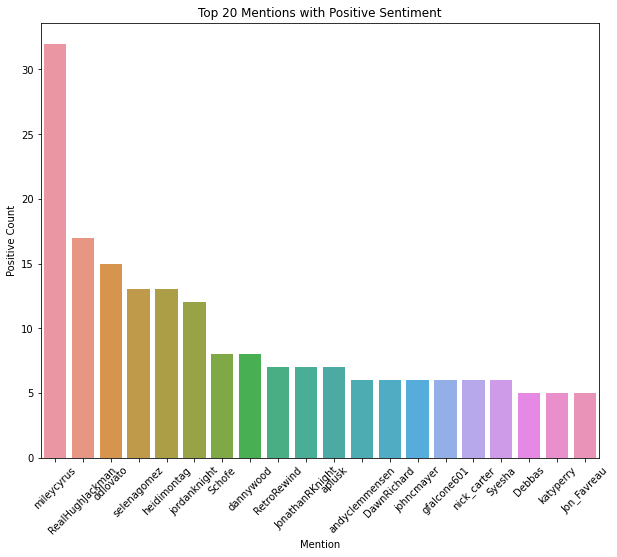

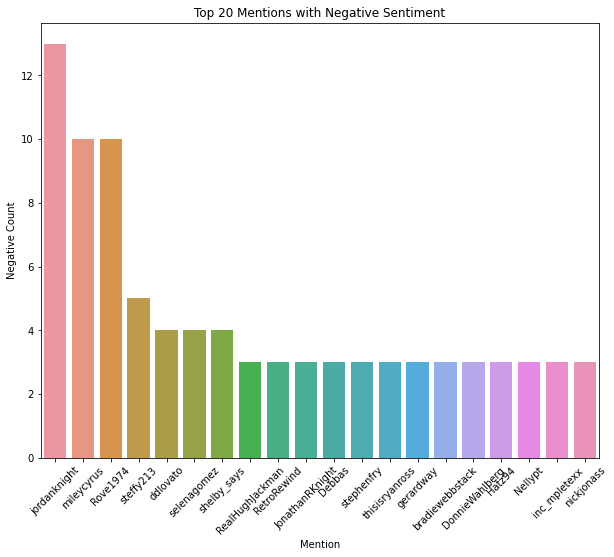

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Top 20 Mentions with Positive Sentiment
plt.figure(figsize=(10, 8))
sns.barplot(x="mention", y="positive_count", data=mention_pdf.nlargest(20, 'positive_count'))
plt.title('Top 20 Mentions with Positive Sentiment')
plt.xticks(rotation=45)
plt.xlabel('Mention')
plt.ylabel('Positive Count')
plt.show()

# Plot Top 20 Mentions with Negative Sentiment
plt.figure(figsize=(10, 8))
sns.barplot(x="mention", y="negative_count", data=mention_pdf.nlargest(20, 'negative_count'))
plt.title('Top 20 Mentions with Negative Sentiment')
plt.xticks(rotation=45)
plt.xlabel('Mention')
plt.ylabel('Negative Count')
plt.show()


## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [ ]:
%run ./includes/utilities

In [ ]:
%run ./includes/includes

In [ ]:
active_streams = spark.streams.active
if active_streams:
    print("Active Streams:")
    for stream in active_streams:
        print(f"- {stream.name}")
else:
    print("No active streams.")

No active streams.


In [ ]:
for stream in active_streams:
    stream.stop()
    print(f"Stopped stream: {stream.name}")

VERY IMPORTANT TO UNDERSTAND THE USE OF THESE VARIABLES! Please ask if you are confused about their use. 
 
 Variable Name Value Description 
 TWEET_BUCKET_NAME voc-75-databricks-data AWS S3 Bucket Name where the tweets are coming into your system. 
 TWEET_BUCKET_URL https://voc-75-databricks-data.s3.amazonaws.com/ AWS S3 Bucket URL where the tweets are coming into your system. 
 TWEET_SOURCE_PATH s3a://voc-75-databricks-data/voc_volume/ AWS S3 Path where the tweets are coming into your system. 
 USER_DIR /tmp/labuser104917-3010936/ Path to the local storage (dbfs) for your project. 
 BRONZE_CHECKPOINT /tmp/labuser104917-3010936/bronze.checkpoint Store your Bronze Checkpoint data here. 
 BRONZE_DELTA /tmp/labuser104917-3010936/bronze.delta Store your Bronze Delta Table here. 
 SILVER_CHECKPOINT /tmp/labuser104917-3010936/silver.checkpoint Store your Silver Checkpoint data here. 
 SILVER_DELTA /tmp/labuser104917-3010936/silver.delta Store your Silver Delta Table here. 
 GOLD_CHECKPOINT /tmp/labuser104917-3010936/gold.checkpoint Store your Gold Checkpoint data here. 
 GOLD_DELTA /tmp/labuser104917-3010936/gold.delta Store your Gold Delta Table here. 
 MODEL_NAME HF_TWEET_SENTIMENT Load this production model 
 HF_MODEL_NAME finiteautomata/bertweet-base-sentiment-analysis The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis

the includes are included


In [ ]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
elapsed_time = END_TIME - START_TIME  # Assuming start_time is defined earlier
print(f"Elapsed Time: {elapsed_time} seconds")

Elapsed Time: 9.378004312515259 seconds


### ENTER YOUR MARKDOWN HERE
1. **Spill**:
   - Findings: No data spillage is detected in the system, as indicated by the consistent partition sizes across jobs and the small file sizes at the source.
   - Consequences: The absence of disproportionately large files ensures efficient loading and processing, effectively preventing performance degradation due to disk spillage.

2. **Skew**:
   - Findings: There is no apparent data skew in the job executions, thanks to uniform file sizes and the effective use of Adaptive Query Execution (AQE) to optimize partition handling.
   - Consequences: The even distribution of data ensures that no single node or process becomes overloaded, thereby avoiding potential bottlenecks.  -
3. **Shuffle**:
   - Findings: Shuffle operations are necessary due to wide transformations such as GroupBy, OrderBy, Aggregate, and Explode.
   - Optimization Strategy: By aligning the number of shuffle partitions with the number of processor cores, data movement across partitions is optimized, minimizing potential delays.
   - Consequences: Although shuffle processes are inherent to the operations performed, the careful configuration of shuffle partitions reduces the time overhead associated with these operations.

4. **Storage**:
   - Findings: Initial storage in JSON format within an S3 bucket is suboptimal due to the large number of small files, which leads to inefficient read times.
   - Action Steps: After the initial read phase, data is efficiently stored in Delta tables (Bronze, Silver, and Gold), indicating that improvements should target the initial ingestion phase. Possible solutions include consolidating files before processing or modifying the read mechanisms.

5. **Serialization**:
  - Findings: The serialization of the ML model for sentiment analysis via a User Defined Function (UDF) is particularly time-consuming.
  - Potential Improvements: Although the specific UDF for sentiment analysis cannot be replaced, optimizing other UDFs, such as those used for extracting mentions in the Silver table, could enhance overall efficiency. Employing built-in Spark functions in place of custom UDFs might reduce dependency on less efficient custom solutions.

